In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Conv2DTranspose, CenterCrop, Concatenate

In [2]:
SEGMENTATED_DATA_FOLDER = '../../data/PASCAL/VOC2012/SegmentationObject'
ORIGINAL_DATA_FOLDER = '../../data/PASCAL/VOC2012/JPEGImages'

Image shape: (500, 375)
Image 2 shape: (353, 500)


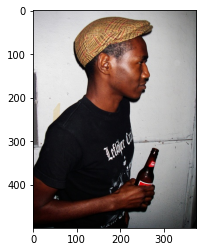

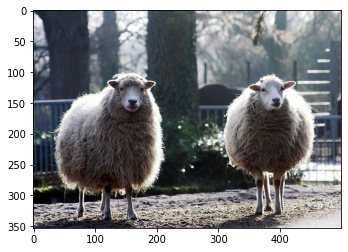

In [3]:
img = cv.imread(f"{ORIGINAL_DATA_FOLDER}/2007_000999.jpg")
img2 = cv.imread(f"{ORIGINAL_DATA_FOLDER}/2007_000925.jpg")

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

mask = cv.imread(f"{SEGMENTATED_DATA_FOLDER}/2007_000999.png", cv.IMREAD_GRAYSCALE)
mask2 = cv.imread(f"{SEGMENTATED_DATA_FOLDER}/2007_000925.png", cv.IMREAD_GRAYSCALE)

print(f"Image shape: {mask.shape}")
print(f"Image 2 shape: {mask2.shape}")

plt.imshow(img)
plt.show()
plt.imshow(img2)
plt.show()


In [4]:
def create_standard_unet():
    # ======================== CONTRACTING PATH ==========================

    inputs = Input(shape=(572, 572, 1))                      # 572x572x1

    conv_1_1 = Conv2D(64, 3, activation='relu')(inputs)      # 570x570x64
    conv_1_2 = Conv2D(64, 3, activation='relu')(conv_1_1)    # 568x568x64

    pool_1 = MaxPool2D((2,2), strides=2)(conv_1_2)           # 284x284x64

    conv_2_1 = Conv2D(128, 3, activation='relu')(pool_1)     # 282x282x128
    conv_2_2 = Conv2D(128, 3, activation='relu')(conv_2_1)   # 280x280x128

    pool_2 = MaxPool2D((2,2), strides=2)(conv_2_2)           # 140x140x128

    conv_3_1 = Conv2D(256, 3, activation='relu')(pool_2)     # 138x138x256
    conv_3_2 = Conv2D(256, 3, activation='relu')(conv_3_1)   # 136x136x256

    pool_3 = MaxPool2D((2,2), strides=2)(conv_3_2)           # 68x68x256

    conv_4_1 = Conv2D(512, 3, activation='relu')(pool_3)     # 66x66x512
    conv_4_2 = Conv2D(512, 3, activation='relu')(conv_4_1)   # 64x64x512

    pool_4 = MaxPool2D((2,2), strides=2)(conv_4_2)           # 32x32x512

    conv_5_1 = Conv2D(1024, 3, activation='relu')(pool_4)    # 30x30x1024
    conv_5_2 = Conv2D(1024, 3, activation='relu')(conv_5_1)  # 28x28x1024

    # ======================== EXPANDING PATH ============================

    up_1 = Conv2DTranspose(512, 2, strides=2, padding='same')(conv_5_2)   # 56x56x512
    conv_4_2_crop = CenterCrop(up_1.shape[1], up_1.shape[2])(conv_4_2)    # 56x56x512

    concat_1 = Concatenate()([up_1, conv_4_2_crop])                       # 56x56x1024
    conv_6_1 = Conv2D(512, 3, activation='relu')(concat_1)                # 54x54x512
    conv_6_2 = Conv2D(512, 3, activation='relu')(conv_6_1)                # 52x52x512

    up_2 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv_6_2)   # 104x104x256
    conv_3_2_crop = CenterCrop(up_2.shape[1], up_2.shape[2])(conv_3_2)    # 104x104x256

    concat_2 = Concatenate()([up_2, conv_3_2_crop])                       # 104x104x512
    conv_7_1 = Conv2D(256, 3, activation='relu')(concat_2)                # 102x102x256
    conv_7_2 = Conv2D(256, 3, activation='relu')(conv_7_1)                # 100x100x256

    up_3 = Conv2DTranspose(128, 2, strides=2, padding="same")(conv_7_2)   # 200x200x128
    conv_2_2_crop = CenterCrop(up_3.shape[1], up_3.shape[2])(conv_2_2)    # 200x200x128

    concat_3 = Concatenate()([up_3, conv_2_2_crop])                       # 200x200x256
    conv_8_1 = Conv2D(128, 3, activation='relu')(concat_3)                # 198x198x128
    conv_8_2 = Conv2D(128, 3, activation='relu')(conv_8_1)                # 196x196x128

    up_4 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv_8_2)    # 392x392x64
    conv_1_2_crop = CenterCrop(up_4.shape[1], up_4.shape[2])(conv_1_2)    # 392x392x64

    concat_4 = Concatenate()([up_4, conv_1_2_crop])                       # 392x392x128
    conv_9_1 = Conv2D(64, 3, activation='relu')(concat_4)                 # 390x390x64
    conv_9_2 = Conv2D(64, 3, activation='relu')(conv_9_1)                 # 388x388x64
    conv_9_3 = Conv2D(2, 1, activation='softmax')(conv_9_2)               # 388x388x2

    unet = tf.keras.Model(inputs, conv_9_3)
    return unet

In [5]:
unet = create_standard_unet()

unet.summary(line_length=130)

Model: "model"
__________________________________________________________________________________________________________________________________
 Layer (type)                             Output Shape                 Param #         Connected to                               
 input_1 (InputLayer)                     [(None, 572, 572, 1)]        0               []                                         
                                                                                                                                  
 conv2d (Conv2D)                          (None, 570, 570, 64)         640             ['input_1[0][0]']                          
                                                                                                                                  
 conv2d_1 (Conv2D)                        (None, 568, 568, 64)         36928           ['conv2d[0][0]']                           
                                                                    